# Deterministic VFSS Bolus Segmentation

Pipeline assembled from photometric, temporal, motion, and edge priors with optional lightweight tuning.

**How to use**
- Place VFSS frames in `images/` and binary bolus masks in `masks/` (matching filenames).
- Adjust the configuration cell to match your acquisition (tile sizes, radii, weights).
- Run the pipeline cell to generate probability maps, masks, and quick metrics.

In [73]:
from __future__ import annotations
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Optional, Sequence

import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, gaussian_laplace
from scipy.special import expit
from skimage import morphology, measure
from skimage.restoration import denoise_tv_chambolle
from skimage.filters import sobel
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [74]:
@dataclass
class PreprocessConfig:
    clip_limit: float = 2.5
    tile_grid_size: tuple = (8, 8)
    cutoff: float = 0.06  # normalized Butterworth cutoff
    tv_weight: float = 0.02

@dataclass
class FusionWeights:
    w_H: float = 0
    w_D: float = 1.8
    w_M: float = 0
    w_G: float = 1.0
    w_A: float = 0.5
    bias: float = -1.5

@dataclass
class RegularizationConfig:
    edge_gamma: float = 3.0
    iterations: int = 2
    threshold: float = 0.3
    open_radius: int = 1
    close_radius: int = 3
    keep_components: int = 2
    min_component_size: int = 200

@dataclass
class PipelineConfig:
    preprocess: PreprocessConfig = field(default_factory=PreprocessConfig)
    fusion: FusionWeights = field(default_factory=FusionWeights)
    regularize: RegularizationConfig = field(default_factory=RegularizationConfig)
    ema_alpha: float = 0.4
    top_hat_radius: int = 15
    log_sigmas: tuple = (1.0, 1.6, 2.4)
    corridor_percentile: float = 65.0
    corridor_dilate: int = 8
    flow_params: dict = field(default_factory=lambda: dict(pyr_scale=0.5, levels=3, winsize=21, iterations=3, poly_n=5, poly_sigma=1.2, flags=0))

In [75]:
def load_grayscale_sequence(image_dir: Path, limit: Optional[int] = None, stride: int = 1) -> List[Path]:
    image_dir = Path(image_dir)
    paths = sorted(p for p in image_dir.glob('*') if p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.tif', '.tiff'})
    if stride > 1:
        paths = paths[::stride]
    if limit is not None:
        paths = paths[:limit]
    if not paths:
        raise FileNotFoundError(f'No frames found in {image_dir}')
    return paths

def read_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f'Could not load {path}')
    return img

def normalize01(arr: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    arr = arr.astype(np.float32)
    mn, mx = float(arr.min()), float(arr.max())
    if mx - mn < eps:
        return np.zeros_like(arr, dtype=np.float32)
    return (arr - mn) / (mx - mn)

def preprocess_frame(img: np.ndarray, cfg: PreprocessConfig) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=cfg.clip_limit, tileGridSize=cfg.tile_grid_size)
    eq = clahe.apply(img)
    norm = np.clip(eq.astype(np.float32) / 255.0, 1e-3, 1.0)
    log_img = np.log(norm)
    sigma = max(1.0, min(img.shape) * cfg.cutoff * 4)
    low = gaussian_filter(log_img, sigma=sigma)
    high = log_img - low
    homo = normalize01(np.exp(high))
    denoised = denoise_tv_chambolle(homo, weight=cfg.tv_weight)
    return denoised.astype(np.float32)

def preprocess_sequence(frames: List[np.ndarray], cfg: PipelineConfig) -> List[np.ndarray]:
    return [preprocess_frame(frame, cfg.preprocess) for frame in frames]

In [76]:
def compute_top_hat_sequence(preprocessed: List[np.ndarray], radius: int) -> List[np.ndarray]:
    selem = morphology.disk(radius)
    return [normalize01(morphology.black_tophat(img, footprint=selem)) for img in preprocessed]

def compute_temporal_diff_sequence(preprocessed: List[np.ndarray]) -> List[np.ndarray]:
    diffs: List[np.ndarray] = []
    for idx in range(len(preprocessed)):
        cur = preprocessed[idx]
        prev = preprocessed[idx - 1] if idx > 0 else cur
        nxt = preprocessed[idx + 1] if idx < len(preprocessed) - 1 else cur
        stack = np.stack([np.abs(cur - prev), np.abs(cur - nxt)], axis=0)
        diffs.append(np.median(stack, axis=0))
    return diffs

def smooth_temporal_features(features: List[np.ndarray], alpha: float) -> List[np.ndarray]:
    smoothed: List[np.ndarray] = []
    ema = None
    for feat in features:
        feat_norm = normalize01(feat)
        if ema is None:
            ema = feat_norm
        else:
            ema = alpha * feat_norm + (1 - alpha) * ema
        smoothed.append(ema.copy())
    return smoothed

def compute_motion_sequence(preprocessed: List[np.ndarray], flow_params: dict) -> List[np.ndarray]:
    mags: List[np.ndarray] = [np.zeros_like(preprocessed[0], dtype=np.float32)]
    for idx in range(1, len(preprocessed)):
        prev = preprocessed[idx - 1].astype(np.float32)
        cur = preprocessed[idx].astype(np.float32)
        flow = cv2.calcOpticalFlowFarneback(prev, cur, None, **flow_params)
        mags.append(normalize01(np.linalg.norm(flow, axis=-1)))
    return mags

def compute_gradient_sequence(preprocessed: List[np.ndarray], sigmas: Sequence[float]) -> List[np.ndarray]:
    feats: List[np.ndarray] = []
    for img in preprocessed:
        accum = np.zeros_like(img, dtype=np.float32)
        for sigma in sigmas:
            lap = -gaussian_laplace(img, sigma=sigma)
            accum += np.maximum(0, lap)
        feats.append(normalize01(accum))
    return feats

def build_corridor(preprocessed: List[np.ndarray], percentile: float, dilate: int) -> np.ndarray:
    stack = np.stack(preprocessed, axis=0)
    std_map = stack.std(axis=0)
    thresh = np.percentile(std_map, percentile)
    mask = std_map > thresh
    mask = morphology.binary_closing(mask, morphology.disk(10))
    mask = morphology.remove_small_objects(mask, min_size=600)
    if mask.any():
        mask = morphology.binary_dilation(mask, morphology.disk(dilate))
    else:
        mask = np.ones_like(preprocessed[0], dtype=bool)
    return mask.astype(np.float32)

def compute_priors(preprocessed: List[np.ndarray], cfg: PipelineConfig) -> Dict[str, List[np.ndarray]]:
    H = compute_top_hat_sequence(preprocessed, cfg.top_hat_radius)
    D = smooth_temporal_features(compute_temporal_diff_sequence(preprocessed), cfg.ema_alpha)
    M = compute_motion_sequence(preprocessed, cfg.flow_params)
    G = compute_gradient_sequence(preprocessed, cfg.log_sigmas)
    A = build_corridor(preprocessed, cfg.corridor_percentile, cfg.corridor_dilate)
    return dict(H=H, D=D, M=M, G=G, A=A)

In [77]:
def edge_aware_regularize(prob: np.ndarray, image: np.ndarray, cfg: RegularizationConfig) -> np.ndarray:
    img = image.astype(np.float32)
    if img.max() > 1.0:
        img /= 255.0
    edge = sobel(img)
    weight = np.exp(-cfg.edge_gamma * edge)
    result = prob.copy()
    for _ in range(cfg.iterations):
        smooth = gaussian_filter(result, sigma=1)
        result = weight * smooth + (1 - weight) * prob
        result = np.clip(result, 0, 1)
    return result

def postprocess_mask(prob: np.ndarray, cfg: RegularizationConfig, corridor: Optional[np.ndarray]) -> np.ndarray:
    mask = prob >= cfg.threshold
    if corridor is not None:
        mask &= corridor.astype(bool)
    if cfg.min_component_size > 0:
        mask = morphology.remove_small_objects(mask, cfg.min_component_size)
    if cfg.open_radius > 0:
        mask = morphology.opening(mask, morphology.disk(cfg.open_radius))
    if cfg.close_radius > 0:
        mask = morphology.closing(mask, morphology.disk(cfg.close_radius))
    labeled = measure.label(mask)
    if cfg.keep_components > 0 and labeled.max() > cfg.keep_components:
        areas = np.array([(labeled == (i + 1)).sum() for i in range(labeled.max())])
        order = np.argsort(areas)[::-1]
        keep = np.zeros_like(mask)
        for idx in order[:cfg.keep_components]:
            keep |= labeled == (idx + 1)
        mask = keep
    return mask.astype(np.uint8)

def fuse_and_segment(raw_frames: List[np.ndarray], priors: Dict[str, List[np.ndarray]], cfg: PipelineConfig):
    corridor = priors['A']
    probs: List[np.ndarray] = []
    masks: List[np.ndarray] = []
    for idx, frame in enumerate(raw_frames):
        logit = (
            cfg.fusion.w_H * priors['H'][idx]
            + cfg.fusion.w_D * priors['D'][idx]
            + cfg.fusion.w_M * priors['M'][idx]
            + cfg.fusion.w_G * priors['G'][idx]
            + cfg.fusion.w_A * corridor
            + cfg.fusion.bias
        )
        prob = expit(logit)
        prob = edge_aware_regularize(prob, frame, cfg.regularize)
        mask = postprocess_mask(prob, cfg.regularize, corridor)
        probs.append(prob)
        masks.append(mask)
    return probs, masks, corridor

def process_sequence(image_paths: Sequence[Path], cfg: PipelineConfig):
    raw_frames = [read_gray(p) for p in image_paths]
    preprocessed = preprocess_sequence(raw_frames, cfg)
    priors = compute_priors(preprocessed, cfg)
    probs, masks, corridor = fuse_and_segment(raw_frames, priors, cfg)
    return dict(paths=list(image_paths), raw=raw_frames, preprocessed=preprocessed, priors=priors, probabilities=probs, masks=masks, corridor=corridor)

In [78]:
def compute_metrics(pred: np.ndarray, gt: np.ndarray) -> Dict[str, float]:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    tp = inter
    fp = np.logical_and(pred, np.logical_not(gt)).sum()
    fn = np.logical_and(np.logical_not(pred), gt).sum()
    dice = 2 * inter / (pred.sum() + gt.sum() + 1e-6)
    iou = inter / (pred.sum() + gt.sum() - inter + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return dict(dice=dice, iou=iou, precision=precision, recall=recall)

def evaluate_sequence(result: dict, mask_dir: Path) -> List[Dict[str, float]]:
    mask_dir = Path(mask_dir)
    metrics: List[Dict[str, float]] = []
    for path, pred in zip(result['paths'], result['masks']):
        mask_path = mask_dir / path.name
        if not mask_path.exists():
            continue
        gt = read_gray(mask_path) > 0
        metrics.append(compute_metrics(pred, gt))
    return metrics

def summarize_metrics(metrics: List[Dict[str, float]]) -> Dict[str, float]:
    if not metrics:
        return {}
    keys = metrics[0].keys()
    return {k: float(np.mean([m[k] for m in metrics])) for k in keys}

In [79]:
# Configure paths and pipeline hyperparameters
image_dir = Path('images')
mask_dir = Path('masks')
config = PipelineConfig()
frame_limit = 24  # set to None to use all frames
frame_stride = 1
frame_paths = load_grayscale_sequence(image_dir, limit=frame_limit, stride=frame_stride)
result = process_sequence(frame_paths, config)
metrics = evaluate_sequence(result, mask_dir)
summary = summarize_metrics(metrics)
print(f'Frames processed: {len(result["raw"])}')
if summary:
    print('Average metrics:', summary)
else:
    print('No matching masks found; skipping metric summary.')

Frames processed: 24
Average metrics: {'dice': 0.4250614882365727, 'iou': 0.2734041712043943, 'precision': 0.3189580995134573, 'recall': 0.7264421666034494}


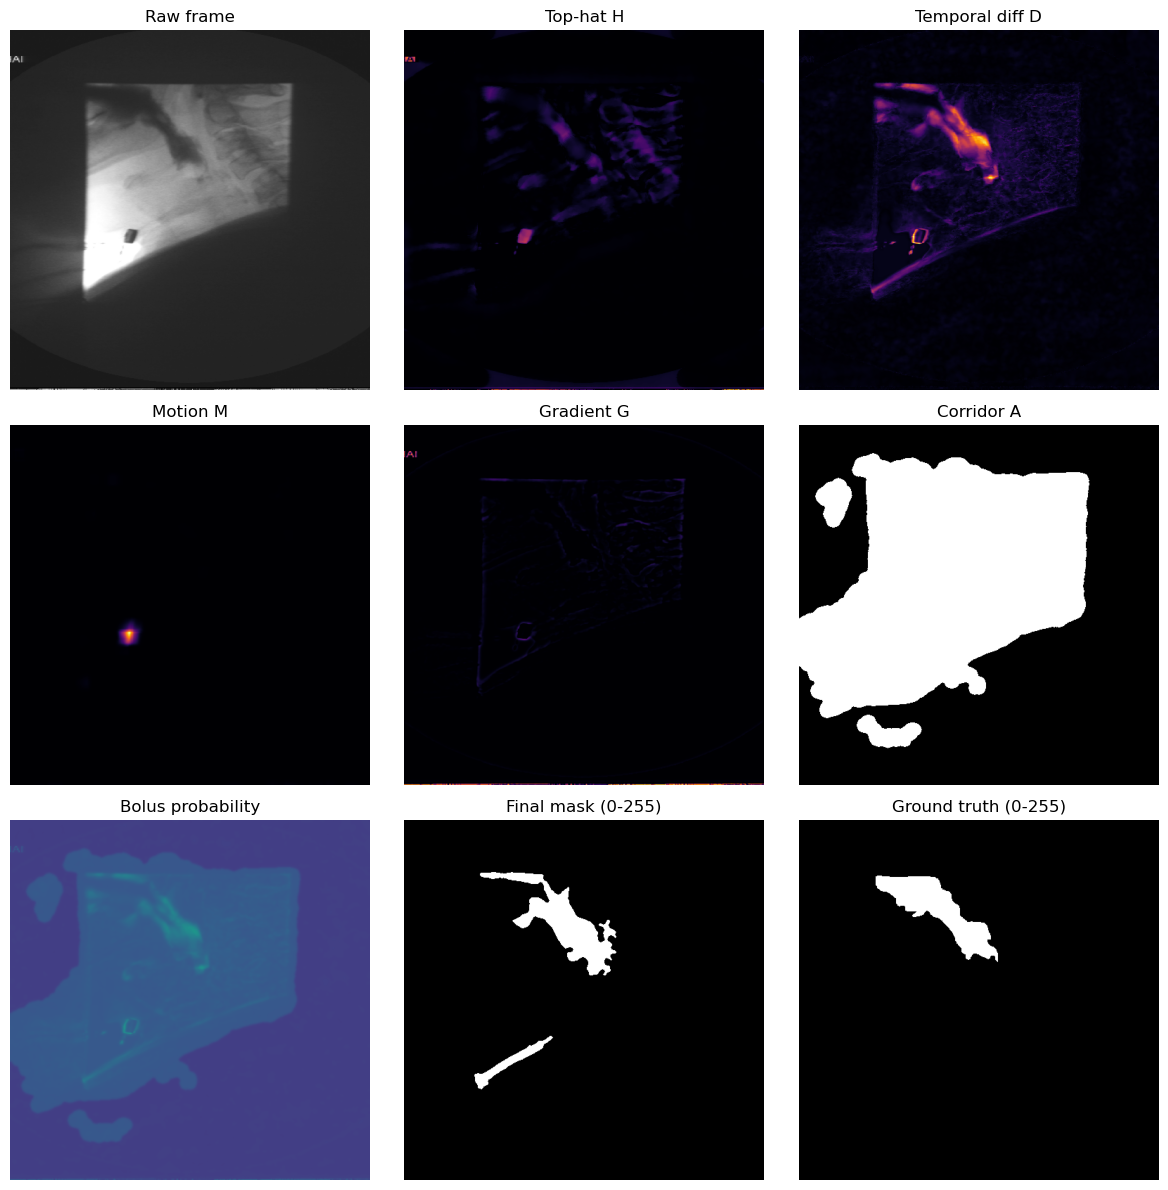

In [80]:
# Visualize a sample frame with priors, probability, and segmentation
import math

frame_index = min(5, len(result['raw']) - 1)
raw = result['raw'][frame_index]
priors = result['priors']
prob = result['probabilities'][frame_index]
mask = (result['masks'][frame_index].astype(np.float32) * 255)  # scale binary mask for display
corridor = result['corridor']
mask_path = mask_dir / result['paths'][frame_index].name
gt_mask = read_gray(mask_path) if mask_path.exists() else None
if gt_mask is not None and gt_mask.max() <= 1:
    gt_mask = (gt_mask.astype(np.float32) * 255).astype(np.uint8)

panels = [
    ('Raw frame', raw, 'gray', dict()),
    ('Top-hat H', priors['H'][frame_index], 'inferno', dict()),
    ('Temporal diff D', priors['D'][frame_index], 'inferno', dict()),
    ('Motion M', priors['M'][frame_index], 'inferno', dict()),
    ('Gradient G', priors['G'][frame_index], 'inferno', dict()),
    ('Corridor A', corridor, 'gray', dict()),
    ('Bolus probability', prob, 'viridis', dict(vmin=0, vmax=1)),
    ('Final mask (0-255)', mask, 'gray', dict(vmin=0, vmax=255)),
]

if gt_mask is not None:
    panels.append(('Ground truth (0-255)', gt_mask, 'gray', dict(vmin=0, vmax=255)))

cols = 3
rows = math.ceil(len(panels) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = np.atleast_1d(axs).flatten()

for ax, (title, img, cmap, imshow_kwargs) in zip(axs, panels):
    ax.imshow(img, cmap=cmap, **imshow_kwargs)
    ax.set_title(title)
    ax.axis('off')

for ax in axs[len(panels):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [81]:
# Optional: fit fusion weights via logistic regression on current sequence
# Uncomment to retrain weights with labelled data (requires scikit-learn).
# from sklearn.linear_model import LogisticRegression
# def fit_fusion_weights(result: dict, mask_dir: Path, sample_per_frame: int = 2000) -> FusionWeights:
#     mask_dir = Path(mask_dir)
#     features, labels = [], []
#     rng = np.random.default_rng(42)
#     for path, H, D, M, G in zip(result['paths'], result['priors']['H'], result['priors']['D'], result['priors']['M'], result['priors']['G']):
#         mask_path = mask_dir / path.name
#         if not mask_path.exists():
#           continue
#         gt = read_gray(mask_path) > 0
#         feats = np.stack([H.ravel(), D.ravel(), M.ravel(), G.ravel(), result['corridor'].ravel()], axis=1)
#         labels_flat = gt.ravel().astype(np.uint8)
#         n = feats.shape[0]
#         take = min(sample_per_frame, n)
#         idx = rng.choice(n, take, replace=False)
#         features.append(feats[idx])
#         labels.append(labels_flat[idx])
#     if not features:
#         raise RuntimeError('No masks found for weight fitting.')
#     X = np.vstack(features)
#     y = np.concatenate(labels)
#     clf = LogisticRegression(max_iter=200, class_weight='balanced')
#     clf.fit(X, y)
#     w_H, w_D, w_M, w_G, w_A = clf.coef_[0]
#     bias = clf.intercept_[0]
#     return FusionWeights(w_H=w_H, w_D=w_D, w_M=w_M, w_G=w_G, w_A=w_A, bias=bias)

# Example usage:
# config.fusion = fit_fusion_weights(result, mask_dir)
# result = process_sequence(frame_paths, config)